## 라이브러리

In [3]:
# 데이터 분석 기본 라이브러리 관련
import os
import sys
import warnings
from tqdm import tqdm_notebook

import numpy as np
import pandas as pd

# EDA 관련
import matplotlib
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# 데이터 전처리 관련
from datetime import datetime
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [5]:
warnings.filterwarnings(action='ignore')
pd.set_option('display.max_columns', 100)
mpl.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False

## 전체적으로 사용되는 함수

In [6]:
def MSG(x):
    if x['SMS\n수신여부']=='수신':
        return 'Y'
    else:
        return 'N'
    
def DateToStr1(x):
    return str(x['최종접수일'])

def DateToStr2(x):
    return str(x['가입일'])

def DateToStr3(x):
    return str(x['최종방문일'])

def StringToStr(x):
    return str(x['고객번호'])

---

## 데이터 불러오기

In [7]:
res=pd.read_excel('./고객data/(갈비명가이상 답십리점)데이터_20210415.xlsx')

In [8]:
msg=pd.read_excel('./고객data/뿌리오지점별고객리스트.xlsx','답십리',skiprows=2)

In [9]:
pos=pd.read_excel('./고객data/갈비명가이상 답십리점_고객현황조회_20210316.xlsx')

In [10]:
pur=pd.read_excel('./고객data/고객구매정보_2004_2103.xlsx')

## 1) 포스 데이터

In [ ]:
pos.head()

**1, 각 열에 결측값 확인**

In [11]:
pos.drop('NO',axis=1,inplace=True)
pos.isnull().sum()

고객번호            0
고객명             0
매장명             0
등급              0
성별              0
생년월일         8782
전화번호            0
핸드폰번호           0
구매금액            0
구매횟수            0
포인트             0
가입일             0
최종방문일           0
우편번호         8782
주소           8783
상세주소         8783
메일주소         8783
SMS\n수신여부       0
기념일          8783
비고           8783
dtype: int64

-> 생년월일, 전화번호, 우편번호, 주소, 상세주소, 메일주소, 기념일, 비고에 대해서 결측치 존재 ( 대부분의 데이터가 결측임 )

**2, 정보가 있는 데이터만 가져와서 새로운 데이터 셋 생성**

In [12]:
pos.drop(['생년월일','전화번호','우편번호','주소','상세주소','메일주소','기념일','비고'],axis=1,inplace=True)

In [ ]:
pos

**3, easyPOS안의 답십리 고객수 8783명**

In [13]:
pos['고객번호'].nunique()

8783

**4, easyPOS안의 모든 고객은 '일반'고객**

In [14]:
pos['등급'].unique()

array(['일반'], dtype=object)

**5, 달 별 가입한 고객의 수 & 그래프**

In [15]:
a=pd.DataFrame(pos['가입일'].value_counts())
a=a.resample('1M').sum()
a

,가입일
2015-02-28,9
2015-03-31,267
2015-04-30,73
2015-05-31,60
2015-06-30,94
...,...
2020-08-31,132
2020-09-30,69
2020-10-31,51
2020-11-30,73


Text(0.5, 1.0, '월별 답십리점 신규 가입자 수')

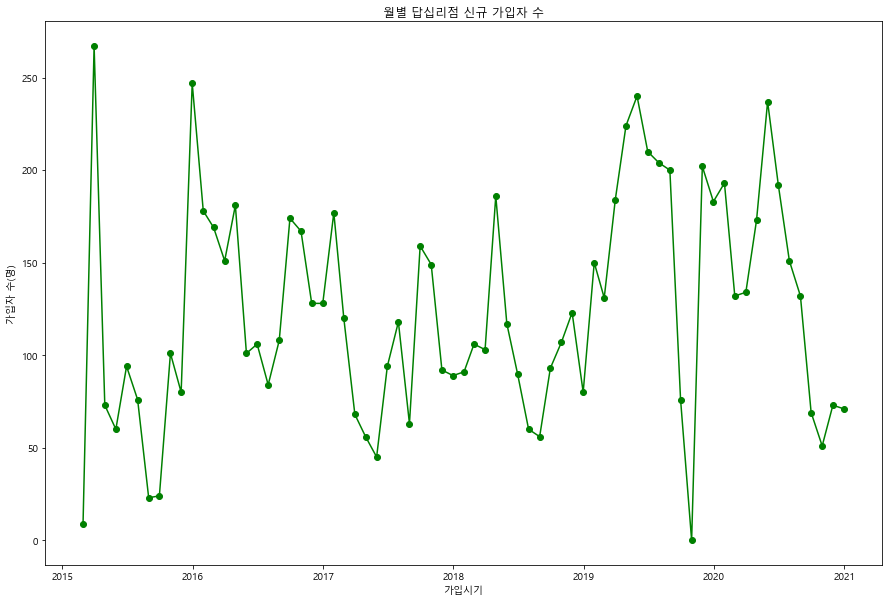

In [16]:
plt.figure(figsize=(15,10))
plt.plot(a.index,a['가입일'], marker="o", color = "green")
plt.xlabel('가입시기')
plt.ylabel('가입자 수(명)')
plt.title('월별 답십리점 신규 가입자 수')

**6, 달 별 최종방문한 고객수 & 그래프**

Text(0.5, 1.0, '월별 답십리점 최종 방문자 수')

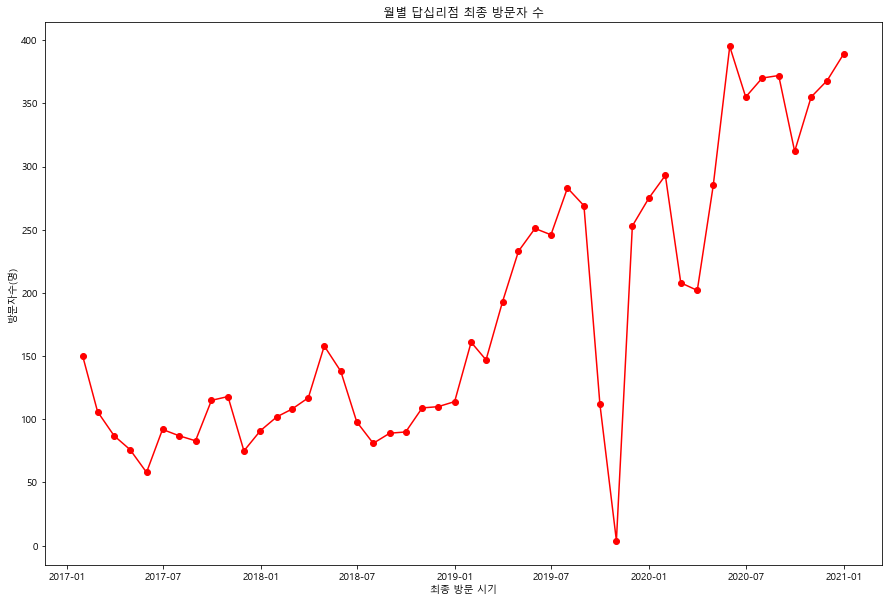

In [17]:
a=pd.DataFrame(pos['최종방문일'].value_counts())
a=a.resample('1M').sum()
plt.figure(figsize=(15,10))
plt.plot(a.index,a['최종방문일'], marker="o", color = "red")
plt.xlabel('최종 방문 시기')
plt.ylabel('방문자수(명)')
plt.title('월별 답십리점 최종 방문자 수')

**다른 데이터 셋과 merge하기 위한 작업**

In [18]:
pos['문자수신여부']=pos.apply(MSG,axis=1)
pos.drop('SMS\n수신여부',axis=1,inplace=True)

In [19]:
pos['연락처']=pos['핸드폰번호'].str.replace('-','')
pos.drop('핸드폰번호',axis=1,inplace=True)
pos['고객번호']=pos.apply(StringToStr,axis=1)
pos['고객번호']=pos['고객번호'].str.pad(width=8,side='left',fillchar='0')

In [20]:
pos['최종방문일']=pos.apply(DateToStr3,axis=1)

**7, pos에 대한 최종 데이터 셋**
- 정보가 없는 변수 제거 : 생년원일, 우편번호, 주소, 상세주소, 메일주소, 기념일, 비고
- 변형 이유 : 다른 데이터 셋과 형태를 동일하게 만들기 위함
- 변형한 변수 : 연락처(000-0000-0000 => 0000000000), SMS\n수신여부(미수신, 수신)-> 문자수신여부 (N,Y)

In [ ]:
pos.head()

## 2) 예약고객 데이터

In [ ]:
res.head()

**1, 총 2770명의 답십리 예약고객**

In [21]:
res.shape

(2770, 18)

**2, 총 예약횟수 = 예약완료 + 취소 + 노쇼**
* 모든 데이터가 이를 만족함. ( 오류 X )

In [22]:
res[res['총 예약횟수'] == (res['예약완료']+ res['취소'] + res['노쇼'])].shape

(2770, 18)

**3, 별칭은 -,진상,vip으로 이루어져있음**
* 1) 별칭이 진상인 고객 정보
* 2) 별칭이 vip인 고객 정보

In [23]:
res['별칭'].unique()

array(['-', '진상', 'vip'], dtype=object)

In [ ]:
res[res['별칭']=='진상']

In [ ]:
res[res['별칭']=='vip']

**4, 고객메모에 대한 정보가 채워져있지 않음**
* 일괄 '-' 처리
* 변수에서 제외

In [24]:
res['고객메모'].unique()

array(['-'], dtype=object)

**5, 고객 그룹은 -,test,씨젠으로 이루어져있음**
* 고객 그룹이 test거나 씨젠인 고객 정보

In [25]:
res['고객그룹'].unique()

array(['-', 'test', '씨젠'], dtype=object)

In [ ]:
res[(res['고객그룹']=='test')|(res['고객그룹']=='씨젠')]

**6, 메뉴이용금액에 대한 정보가 완전치 못한 것 같음**
* 변수에서 제외

In [26]:
res['메뉴이용금액'].unique()

array([     0, 180000,  27000], dtype=int64)

**7, 노쇼레벨 0과 1의 차이점을 설명할 수 없음**
* 변수에서 제외

In [27]:
res['노쇼레벨'].unique()

array([0, 1], dtype=int64)

In [ ]:
res[res['노쇼레벨']==1].head()

In [ ]:
res[res['노쇼레벨']==0].head()

**8, 정보가 불충분한 '고객번호','별칭','고객메모','고객그룹','메뉴이용금액','수신거부일','노쇼레벨'를 변수에서 제거**

In [28]:
res.drop(['고객번호','별칭','고객메모','고객그룹','메뉴이용금액','수신거부일','노쇼레벨'],axis=1,inplace=True)

In [ ]:
res.head()

**다른 데이터 셋과 merge하기 위한 작업**

In [29]:
res.replace('-',np.nan,inplace=True)

In [ ]:
res.head()

In [30]:
res['0']=0
cols=['0','휴대전화번호']
res['휴대전화번호']=res[cols].apply(lambda row:"".join(row.values.astype(str)),axis=1)
res.drop('0',axis=1,inplace=True)

In [ ]:
res.head()

In [31]:
res['최종접수일']=res.apply(DateToStr1,axis=1)
res['가입일']=res.apply(DateToStr2,axis=1)

In [32]:
res['최종방문일']=res.apply(DateToStr3,axis=1)

In [33]:
res['최종접수일']=res['최종접수일'].str[:10]
res['가입일']=res['가입일'].str[:10]
res.rename(columns={'휴대전화번호':'연락처'},inplace=True)

**9, 최종 예약 고객 데이터**
- 정보가 없는 변수 제거 :  고객번호,별칭,고객메모,고객그룹,메뉴이용금액,수신거부일, 노쇼레벨
- 변형 이유 : 다른 데이터 셋과 형태를 동일하게 만들기 위함
- 변형한 변수 : 연락처(0000000000 => 0000000000)

In [ ]:
res.head()

## 3) 뿌리오 데이터

In [ ]:
msg.head()

**뿌리오 답십리 고객수 6403명**

In [34]:
msg.shape

(6403, 3)

**2, 다른 데이터 셋과 합치기 위해**
* 성함 -> 고객명 
* 전화번호 -> 연락처

In [35]:
msg.drop('No.',axis=1,inplace=True)
msg.rename(columns={'성함':'고객명','전화번호':'연락처'},inplace=True)
msg['연락처']=msg['연락처'].str.replace('-','')

In [ ]:
msg.head()

---

## 연락처 처리

**1) 뿌리오 데이터(msg)**
- 총 6403개의 연락처 中 36개 10자리 연락처 ( 과거에 사용되었던 연락처)
- **11자리 연락처만 최종 데이터 셋으로 선정**

In [36]:
msg['연락처'].nunique()

6403

In [37]:
msg.연락처.apply(lambda x: len(x)).value_counts()

11    6367
10      36
Name: 연락처, dtype: int64

In [ ]:
msg[msg.연락처.apply(lambda x: len(x))==10]

In [38]:
msg=msg[msg.연락처.apply(lambda x: len(x))==11]

**2) easyPOS 데이터(pos)**
- 총 8783개의 연락처 中 8671개만 11자리 연락처
- **11자리 연락처만 최종 데이터 셋으로 선정**

In [39]:
pos_phone=pos[['고객명','연락처','최종방문일']]
print(pos_phone.shape)

(8783, 3)


In [ ]:
pos_phone.head()

In [40]:
pos_phone.연락처.apply(lambda x: len(x)).value_counts()

11    8671
10      55
3       52
7        3
8        1
9        1
Name: 연락처, dtype: int64

In [41]:
pos_phone=pos_phone[pos_phone.연락처.apply(lambda x: len(x))==11]

**3) 예약 데이터(res)**
- 총 2770개의 연락처 中 2692개만 11자리 연락처
- **11자리 연락처만 최종 데이터 셋으로 선정**

In [42]:
res_phone=res[['고객명','연락처','최종방문일']]
print(res_phone.shape)

(2770, 3)


In [ ]:
res_phone.head()

In [43]:
res_phone.연락처.apply(lambda x: len(x)).value_counts()

11    2692
10      62
12       9
9        5
14       1
13       1
Name: 연락처, dtype: int64

In [44]:
res_phone=res_phone[res_phone.연락처.apply(lambda x: len(x))==11]

**최종 데이터 합치기 위한 작업**

In [45]:
phone=pd.merge(res_phone,pos_phone,how='outer',on='연락처')

In [ ]:
phone

In [46]:
phone['연락처'].nunique()

10760

In [47]:
phone['최종방문일_x'].fillna('2020-0-0',inplace=True)
phone['최종방문일_y'].fillna('2020-0-0',inplace=True)

In [48]:
same=phone[(phone['고객명_x']==phone['고객명_y'])]
same.drop(['고객명_x','최종방문일_x','최종방문일_y'],axis=1,inplace=True)
same.rename(columns={'고객명_y':'고객명'},inplace=True)

In [ ]:
same

In [49]:
notsame=phone[phone['고객명_x']!=phone['고객명_y']]

In [ ]:
notsame

In [50]:
def NAME(x):
    if x['최종방문일_x']>=x['최종방문일_y']:
        return x['고객명_x']
    else:
        return x['고객명_y']
    
notsame['고객명']=notsame.apply(NAME,axis=1)

In [51]:
notsame.drop(['고객명_x','최종방문일_x','고객명_y','최종방문일_y'],axis=1,inplace=True)

In [ ]:
notsame

In [52]:
phone=pd.concat([same,notsame])

In [ ]:
phone

In [ ]:
phone['연락처'].value_counts()

In [53]:
name_null=phone[phone['고객명'].isnull()]
name_null.drop_duplicates(['연락처'],inplace=True)

In [ ]:
name_null

In [54]:
name_not_null=phone[phone['고객명'].isnull()==0]

In [ ]:
name_not_null

In [55]:
name_not_null['연락처'].nunique()

6158

In [ ]:
name_not_null['연락처'].value_counts()

In [56]:
name_not_null.drop_duplicates(['연락처'],inplace=True)

In [57]:
phone=pd.concat([name_null,name_not_null],axis=0)
phone=phone.sort_values(by=['연락처','고객명'],ascending=[False,False])

In [ ]:
phone

In [58]:
phone.drop_duplicates(['연락처'],inplace=True)

In [ ]:
phone

In [59]:
phone.to_excel('./답십리방문명단.xlsx',index=False, encoding='cp949')

## 포스데이터 + 고객구매정보데이터

In [ ]:
pur.head()

In [60]:
pur.drop('Unnamed: 0',axis=1,inplace=True)

In [61]:
pur.shape

(25829, 14)

In [62]:
pur['고객번호']=pur.apply(StringToStr,axis=1)
pur['고객번호']=pur['고객번호'].str.pad(width=8,side='left',fillchar='0')

In [ ]:
pur.head()

In [63]:
pos_pur=pd.merge(pos,pur,left_on='고객번호',right_on='고객번호',how='left')
pos_pur.shape

(8783, 25)

In [ ]:
pos_pur.head()

In [64]:
PP=pos_pur[pos_pur['최종방문일_x']>='2020-04-01']
print(PP.shape)

(3201, 25)


In [ ]:
PP.head()

In [65]:
PP.isnull().sum()

고객번호        0
고객명_x       0
매장명         0
등급          0
성별          0
구매금액        0
구매횟수        0
포인트         0
가입일         0
최종방문일_x     0
문자수신여부      0
연락처         0
고객명_y      62
누적방문회수     62
최종방문일_y    62
기간방문회수     62
기간방문일수     62
매출수량       62
총매출액       62
순매출액       62
할인금액       62
현금금액       62
카드금액       62
기타금액       62
카드번호       62
dtype: int64

In [66]:
PP[(PP['고객명_x']!=PP['고객명_y'])&(PP['고객명_y'].isnull()==0)]

,고객번호,고객명_x,매장명,등급,성별,구매금액,구매횟수,포인트,가입일,최종방문일_x,문자수신여부,연락처,고객명_y,누적방문회수,최종방문일_y,기간방문회수,기간방문일수,매출수량,총매출액,순매출액,할인금액,현금금액,카드금액,기타금액,카드번호


In [67]:
PP.drop('고객명_y',axis=1,inplace=True)
PP.rename(columns={'고객명_x':'고객명'},inplace=True)

In [ ]:
PP.head()

In [68]:
def Recent(x):
    if str(x['최종방문일_x'])>str(x['최종방문일_y']):
        return x['최종방문일_x']
    else:
        return x['최종방문일_y']

PP['최종방문일']=PP.apply(Recent,axis=1)
PP.drop(['최종방문일_x','최종방문일_y'],axis=1,inplace=True)

In [ ]:
PP

In [69]:
PP.to_excel('./답십리1년방문고객.xlsx',index=False, encoding='cp949')

----

# 고객 등급 나누기 ( 고객 데이터 군집화 )

관련 논문 :  RFM기법과 K-Means 알고리즘을 이용한 고객 분류
- http://www.koreascience.or.kr/article/CFKO201735553776774.pdf

**설명**
- RFM(Recency, Frequency, Monetary)기법과 K-means를 통하여 고객을 등급화
- 최근(Recency)에 얼마나 자주(Frequency)구매했는가, 그 구매의 규모(Monetary)는 얼마인가를 기준으로 고객의 가치 분류
- Recency : 고객 별로 구매날짜 속성 중 가장 최근 항목. 구매날짜를 기준으로 정렬한 후 가장 오래된 날짜를 기준으로 각 고객의 구매 날짜와의 차를 계산 **-> 최종방문일**
- Frequency: 고객 별로 중복되지 않는 주문번호를 count한 값 **-> 구매횟수**
- Monetary : 고객 별로 주문번호를 중복 제거한 후 최종 결제 금액을 합한 값 **-> 구매내역**

### RFM 데이터셋

In [ ]:
pos.head()

In [70]:
DF=pos[['고객번호','최종방문일','구매횟수','구매금액']]
DF.set_index('고객번호',inplace=True)

In [113]:
DF.head()

,frequency,monetary,recency,label,label(ss),label(rs)
고객번호,,,,,,
00106422,1,167500,0,0,0,0
00047852,28,2330700,0,2,3,2
00063344,8,1077500,0,0,0,0
00102491,3,390000,0,0,0,0
00073339,10,716000,0,0,0,0


In [71]:
DF.rename(columns={'구매횟수':'frequency','구매금액':'monetary'},inplace=True)

In [114]:
DF.head()

,frequency,monetary,recency,label,label(ss),label(rs)
고객번호,,,,,,
00106422,1,167500,0,0,0,0
00047852,28,2330700,0,2,3,2
00063344,8,1077500,0,0,0,0
00102491,3,390000,0,0,0,0
00073339,10,716000,0,0,0,0


In [72]:
DF.sort_values(ascending=False,by='최종방문일',inplace=True) #최종방문일을 시간 순서대로 오름차순

In [115]:
DF

,frequency,monetary,recency,label,label(ss),label(rs)
고객번호,,,,,,
00106422,1,167500,0,0,0,0
00047852,28,2330700,0,2,3,2
00063344,8,1077500,0,0,0,0
00102491,3,390000,0,0,0,0
00073339,10,716000,0,0,0,0
...,...,...,...,...,...,...
00069349,1,64000,1460,0,0,0
00069348,1,604000,1460,0,0,0
00069343,1,302500,1460,0,0,0


In [73]:
DF['최종방문일']=DF['최종방문일'].str[:10]

In [116]:
DF

,frequency,monetary,recency,label,label(ss),label(rs)
고객번호,,,,,,
00106422,1,167500,0,0,0,0
00047852,28,2330700,0,2,3,2
00063344,8,1077500,0,0,0,0
00102491,3,390000,0,0,0,0
00073339,10,716000,0,0,0,0
...,...,...,...,...,...,...
00069349,1,64000,1460,0,0,0
00069348,1,604000,1460,0,0,0
00069343,1,302500,1460,0,0,0


In [74]:
def StrToDate(x):
    return datetime.strptime(x['최종방문일'],'%Y-%m-%d').date()

In [75]:
DF['최종방문일']=DF.apply(StrToDate,axis=1)

In [117]:
DF.head()

,frequency,monetary,recency,label,label(ss),label(rs)
고객번호,,,,,,
00106422,1,167500,0,0,0,0
00047852,28,2330700,0,2,3,2
00063344,8,1077500,0,0,0,0
00102491,3,390000,0,0,0,0
00073339,10,716000,0,0,0,0


In [76]:
def RECEN(x):
    return x['recency']-x['최종방문일']

In [77]:
DF['recency']=DF['최종방문일'].iloc[0]
DF['recency']=DF.apply(RECEN,axis=1)

In [118]:
DF

,frequency,monetary,recency,label,label(ss),label(rs)
고객번호,,,,,,
00106422,1,167500,0,0,0,0
00047852,28,2330700,0,2,3,2
00063344,8,1077500,0,0,0,0
00102491,3,390000,0,0,0,0
00073339,10,716000,0,0,0,0
...,...,...,...,...,...,...
00069349,1,64000,1460,0,0,0
00069348,1,604000,1460,0,0,0
00069343,1,302500,1460,0,0,0


In [78]:
def DateToStr(x):
    return str(x['recency'])

DF['recency']=DF.apply(DateToStr,axis=1)

In [119]:
DF

,frequency,monetary,recency,label,label(ss),label(rs)
고객번호,,,,,,
00106422,1,167500,0,0,0,0
00047852,28,2330700,0,2,3,2
00063344,8,1077500,0,0,0,0
00102491,3,390000,0,0,0,0
00073339,10,716000,0,0,0,0
...,...,...,...,...,...,...
00069349,1,64000,1460,0,0,0
00069348,1,604000,1460,0,0,0
00069343,1,302500,1460,0,0,0


In [79]:
DF['recency']=DF['recency'].str.pad(width=18,side='left',fillchar='0')
DF['recency']=DF['recency'].str[:4]

In [120]:
DF

,frequency,monetary,recency,label,label(ss),label(rs)
고객번호,,,,,,
00106422,1,167500,0,0,0,0
00047852,28,2330700,0,2,3,2
00063344,8,1077500,0,0,0,0
00102491,3,390000,0,0,0,0
00073339,10,716000,0,0,0,0
...,...,...,...,...,...,...
00069349,1,64000,1460,0,0,0
00069348,1,604000,1460,0,0,0
00069343,1,302500,1460,0,0,0


In [80]:
def StrToNum(x):
    return int(x['recency'])

DF['recency']=DF.apply(StrToNum,axis=1)

In [121]:
DF.head()

,frequency,monetary,recency,label,label(ss),label(rs)
고객번호,,,,,,
00106422,1,167500,0,0,0,0
00047852,28,2330700,0,2,3,2
00063344,8,1077500,0,0,0,0
00102491,3,390000,0,0,0,0
00073339,10,716000,0,0,0,0


In [81]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8783 entries, 00106422 to 00063150
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   최종방문일      8783 non-null   object
 1   frequency  8783 non-null   int64 
 2   monetary   8783 non-null   int64 
 3   recency    8783 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 343.1+ KB


In [82]:
DF[['recency','frequency','monetary']].describe()

,recency,frequency,monetary
count,8783.000000,8783.000000,8.783000e+03
mean,530.079130,5.410794,5.690773e+05
std,406.620399,9.001429,1.074189e+06
min,0.000000,0.000000,0.000000e+00
25%,186.000000,1.000000,1.000000e+05
50%,423.000000,2.000000,2.365000e+05
75%,801.000000,6.000000,6.030000e+05
max,1460.000000,130.000000,2.941070e+07


**분포도 확인**

(array([8.547e+03, 1.760e+02, 4.000e+01, 1.300e+01, 2.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([       0.,  2941070.,  5882140.,  8823210., 11764280., 14705350.,
        17646420., 20587490., 23528560., 26469630., 29410700.]),
 <a list of 10 Patch objects>)

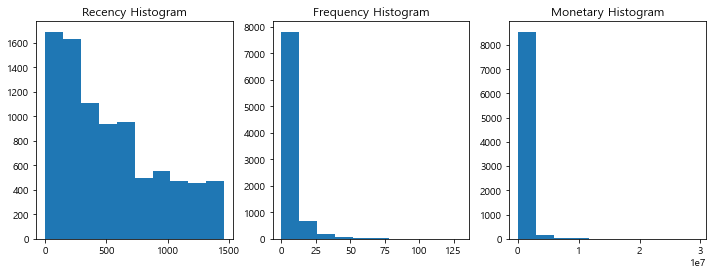

In [83]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12,4), nrows=1, ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(DF['recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(DF['frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(DF['monetary'])

    - 히스토그램을 살펴보면, frequency와 monetary가 매우 skewed된 분포를 가지고 있음
    - 군집화가 한쪽에 집중 될 가능성 多

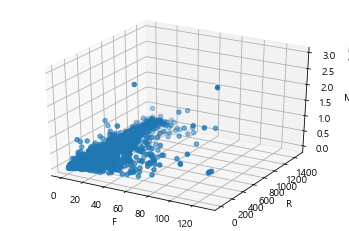

In [84]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = DF['frequency']
y = DF['recency']
z = DF['monetary']

ax.scatter(x, y, z, marker='o')

ax.set_xlabel('F')
ax.set_ylabel('R')
ax.set_zlabel('M')

plt.show()

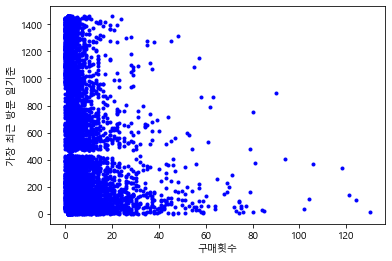

In [85]:
x = DF['frequency']
y = DF['recency']

plt.scatter(x, y, c='b', marker='.')

plt.xlabel('구매횟수')
plt.ylabel('가장 최근 방문 일기준')

plt.show()

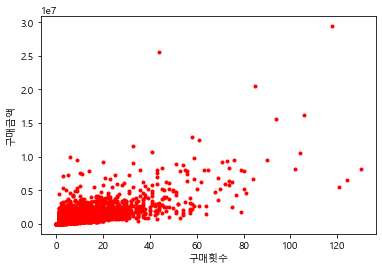

In [86]:
x = DF['frequency']
y = DF['monetary']

plt.scatter(x, y, c='r', marker='.')

plt.xlabel('구매횟수')
plt.ylabel('구매금액')

plt.show()

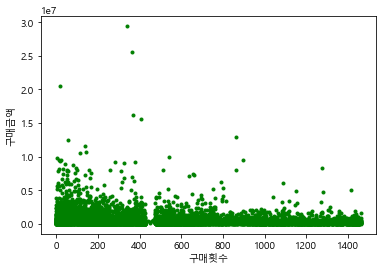

In [87]:
x = DF['recency']
y = DF['monetary']

plt.scatter(x, y, c='g', marker='.')

plt.xlabel('구매횟수')
plt.ylabel('구매금액')

plt.show()

### 라이브러리

In [88]:
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from datetime import datetime
from sklearn.metrics import silhouette_samples,silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm

**1. StandardScaler**
    각 특성의 평균을 0, 분산을 1로 스케일링합니다. 즉 데이터를 정규분포로 만듭니다. 하한값과 상한값이 존재하지 않을 수 있기에, 어떤 알고리즘에서는 문제가 있을 수 있습니다. 회귀보다 분류에 유용합니다.

**2. RobustScaler**
    각 특성들의 중앙값을 0, IQR(제3사분위수-제1사분위수,Q3-Q1)을 1로 스케일링합니다. StandardScaler와 비슷하지만, 이상치의 영향을 최소화합니다.

**3. MinMaxScaler(a,b)**
    각 특성의 하한값을 a, 상한값을 b로 스케일링합니다. a=0, b=1일 경우 Normalization으로 표기할 때도 있습니다. 분류보다 회귀에 유용합니다.

**4. MaxAbsScaler**
    각 특성을 절대값이 0과 1사이가 되도록 스케일링합니다. 즉, 모든 값은 -1과 1사이로 표현되며, 데이터가 양수일 경우 MinMaxScaler와 같습니다.

**5. Normalizer**
    앞의 4가지 스케일러는 각 특성(열)의 통계치를 이용하여 진행됩니다. 그러나 Normalizer의 경우 각 샘플(행)마다 적용되는 방식입니다. 이는 한 행의 모든 특성들 사이의 유클리드 거리(L2 norm)가 1이 되도록 스케일링합니다. 일반적인 데이터 전처리의 상황에서 사용되는 것이 아니라, 모델(특히나 딥러닝) 내 학습 벡터에 적용하며, 특히나 피쳐들이 다른 단위(키, 나이, 소득 등)라면 더더욱 사용하지 않습니다

In [89]:
DF.drop('최종방문일',axis=1,inplace=True)
scaler=MinMaxScaler()
ss=StandardScaler()
rs = RobustScaler()

clusterDF=scaler.fit_transform(DF)
clusterDF2=ss.fit_transform(DF)
clusterDF3 = rs.fit_transform(DF)

### MinMaxScaler

In [90]:
clusterDF

array([[0.00769231, 0.00569521, 0.        ],
       [0.21538462, 0.07924667, 0.        ],
       [0.06153846, 0.03663633, 0.        ],
       ...,
       [0.00769231, 0.01028537, 1.        ],
       [0.00769231, 0.01298847, 1.        ],
       [0.06153846, 0.03230117, 1.        ]])

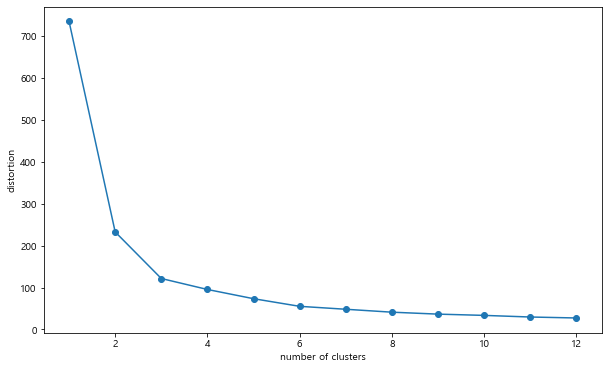

In [91]:
distortions=[]
for i in range(1,13):
    km=KMeans(n_clusters=i,init='random',n_init=10,max_iter=300,tol=1e-04,random_state=0)
    km.fit(clusterDF)
    # lnertia가 군집 내의 분산을 의미
    distortions.append(km.inertia_)
    
plt.figure(figsize=(10,6))
plt.plot(range(1,13),distortions,marker='o')
plt.xlabel('number of clusters')
plt.ylabel('distortion')
plt.show()

### StandardScaler

In [92]:
clusterDF2

array([[-0.49003829, -0.37386361, -1.30369581],
       [ 2.50965634,  1.64004935, -1.30369581],
       [ 0.28766032,  0.47333535, -1.30369581],
       ...,
       [-0.49003829, -0.24818025,  2.28708106],
       [-0.49003829, -0.17416671,  2.28708106],
       [ 0.28766032,  0.3546344 ,  2.28708106]])

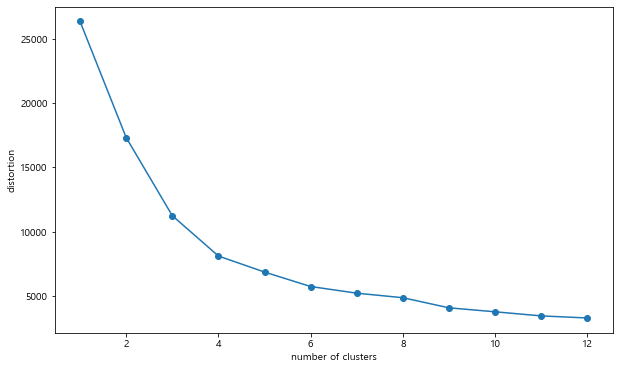

In [93]:
distortions=[]
for i in range(1,13):
    km=KMeans(n_clusters=i,init='random',n_init=10,max_iter=300,tol=1e-04,random_state=0)
    km.fit(clusterDF2)
    # lnertia가 군집 내의 분산을 의미
    distortions.append(km.inertia_)
    
plt.figure(figsize=(10,6))
plt.plot(range(1,13),distortions,marker='o')
plt.xlabel('number of clusters')
plt.ylabel('distortion')
plt.show()

### RobustScaler

In [94]:
clusterDF3

array([[-0.2       , -0.13717694, -0.68780488],
       [ 5.2       ,  4.16341948, -0.68780488],
       [ 1.2       ,  1.67196819, -0.68780488],
       ...,
       [-0.2       ,  0.13121272,  1.68617886],
       [-0.2       ,  0.28926441,  1.68617886],
       [ 1.2       ,  1.41848907,  1.68617886]])

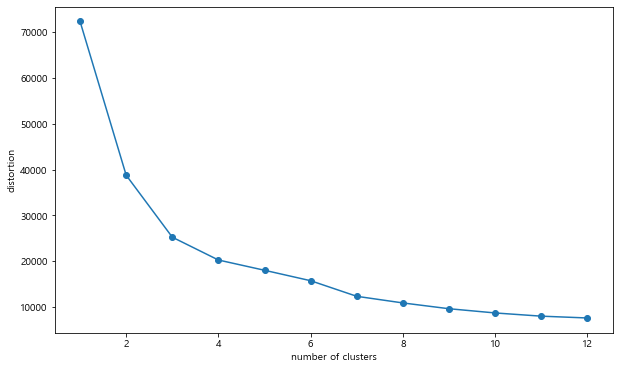

In [95]:
distortions=[]
for i in range(1,13):
    km=KMeans(n_clusters=i,init='random',n_init=10,max_iter=300,tol=1e-04,random_state=0)
    km.fit(clusterDF3)
    # lnertia가 군집 내의 분산을 의미
    distortions.append(km.inertia_)
    
plt.figure(figsize=(10,6))
plt.plot(range(1,13),distortions,marker='o')
plt.xlabel('number of clusters')
plt.ylabel('distortion')
plt.show()

## K-means

1) MinMaxScaler

In [96]:
range_n_clusters=[2,3,4,5,6,7,8,9,10,11,12]

for n_clusters= 2 the average silhouette_score is: 0.5968434421011649
for n_clusters= 3 the average silhouette_score is: 0.5495466752012453
for n_clusters= 4 the average silhouette_score is: 0.4980034946116331
for n_clusters= 5 the average silhouette_score is: 0.5039597438177695
for n_clusters= 6 the average silhouette_score is: 0.47061335849599306
for n_clusters= 7 the average silhouette_score is: 0.4711503538277247
for n_clusters= 8 the average silhouette_score is: 0.44952377033740104
for n_clusters= 9 the average silhouette_score is: 0.43661507881047135
for n_clusters= 10 the average silhouette_score is: 0.4299346598547549
for n_clusters= 11 the average silhouette_score is: 0.43921252858687193
for n_clusters= 12 the average silhouette_score is: 0.4383629322424206


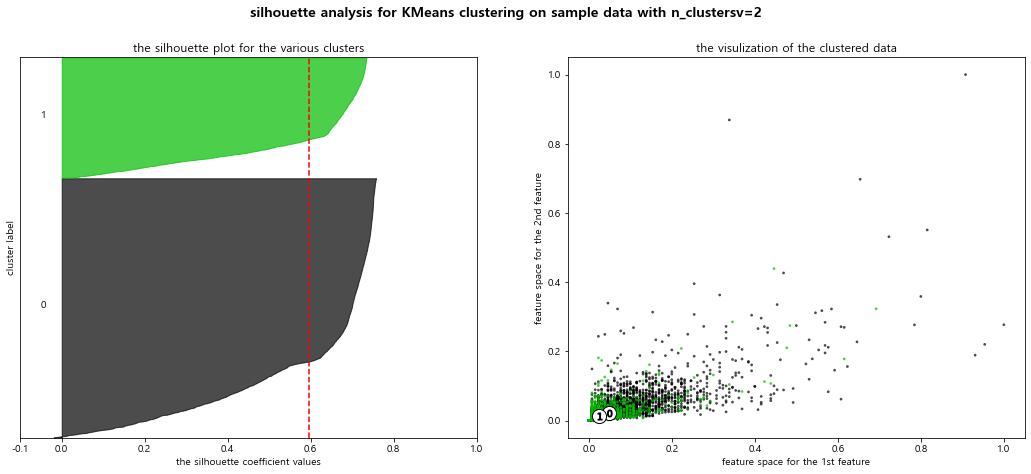

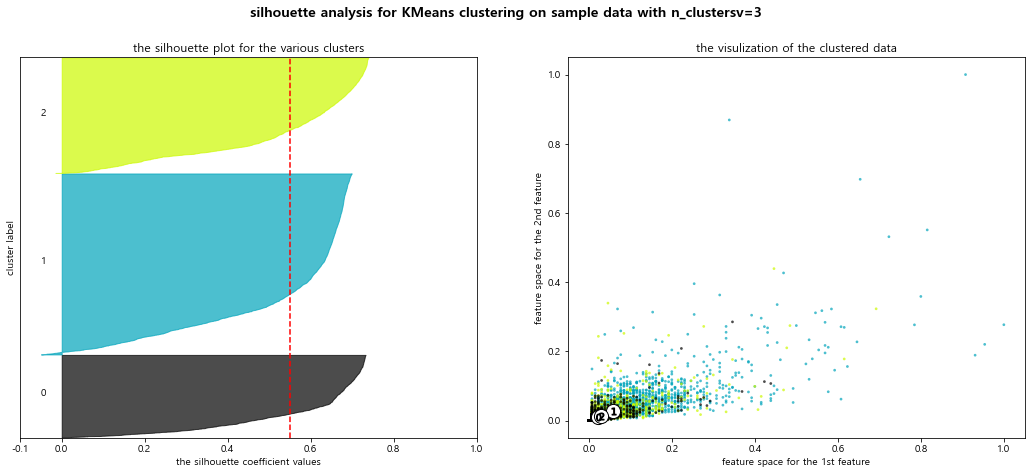

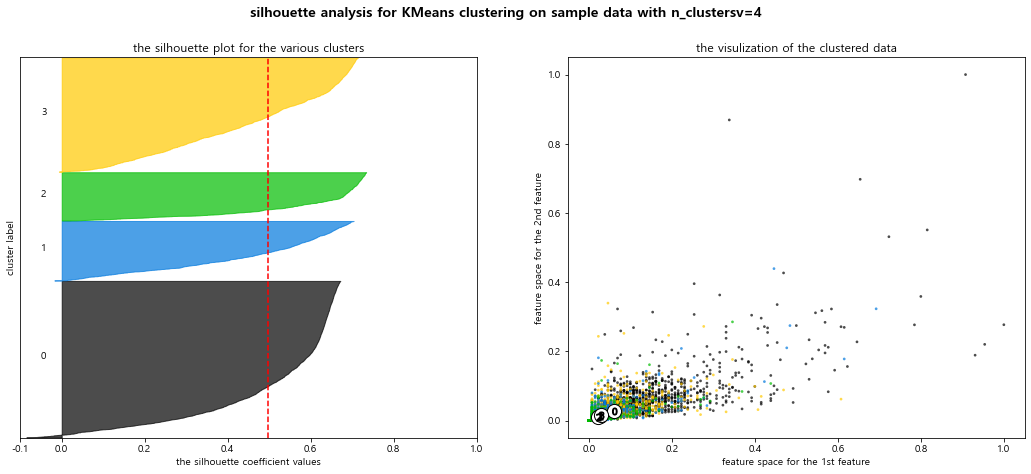

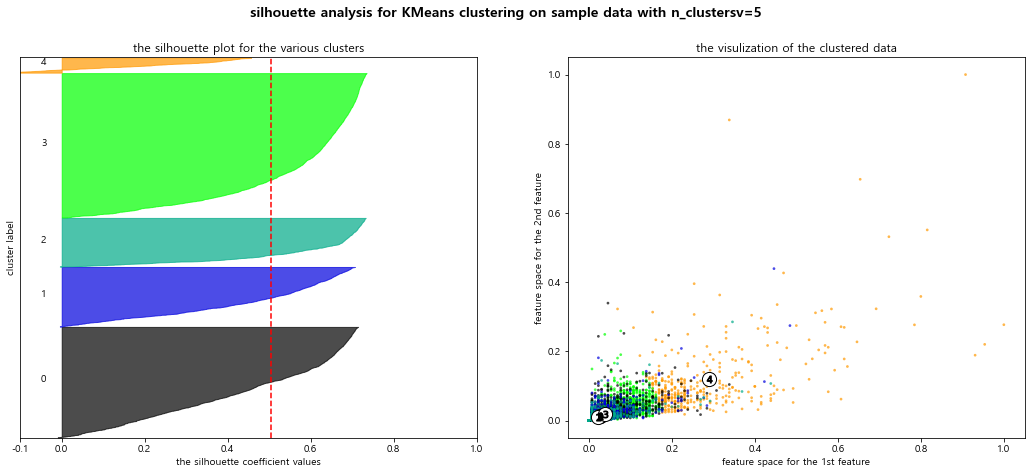

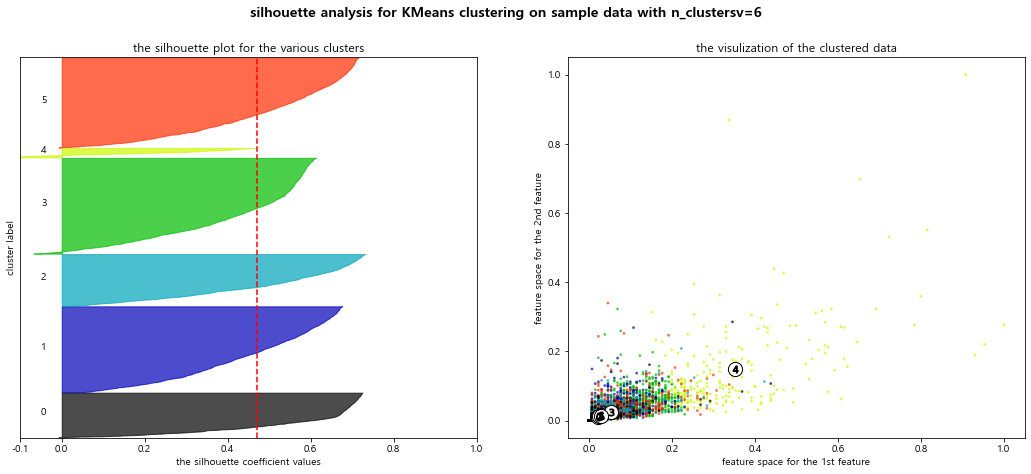

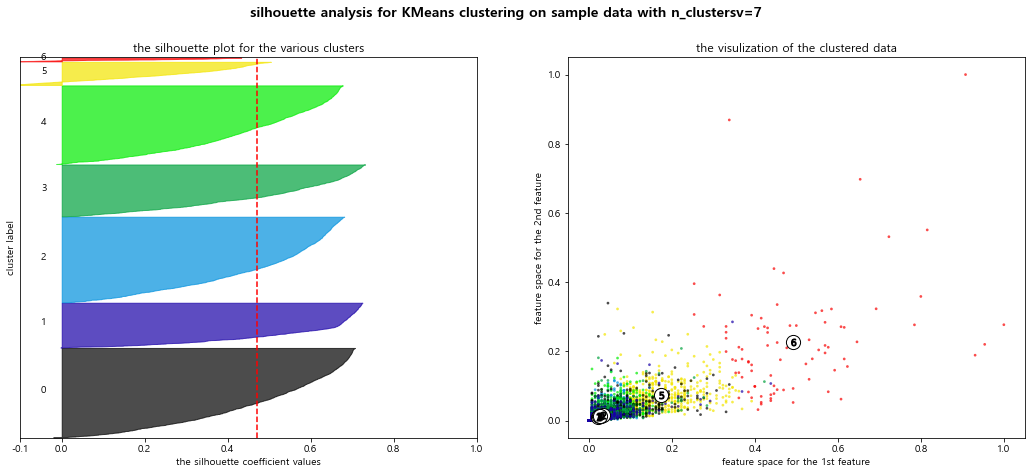

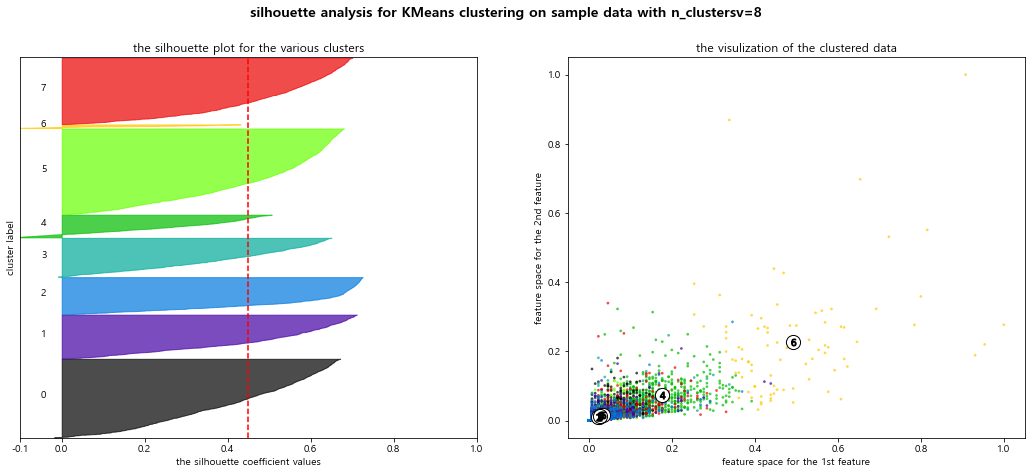

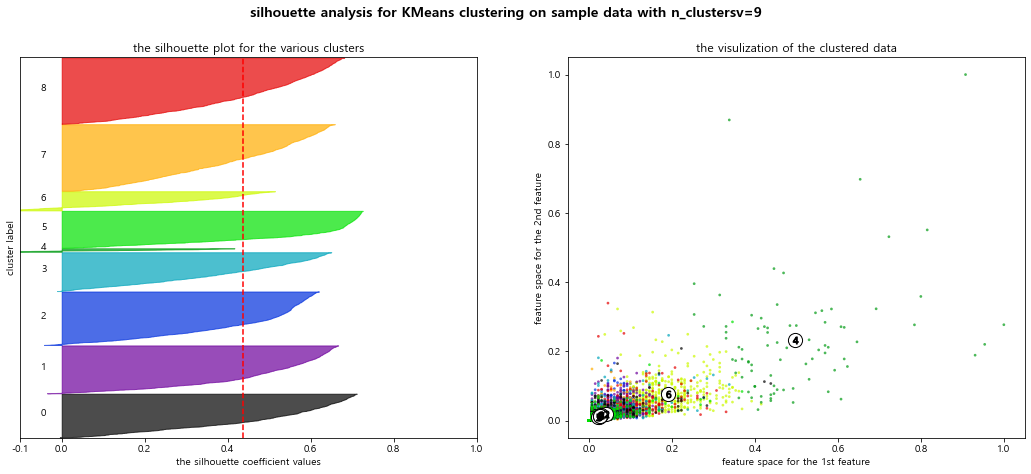

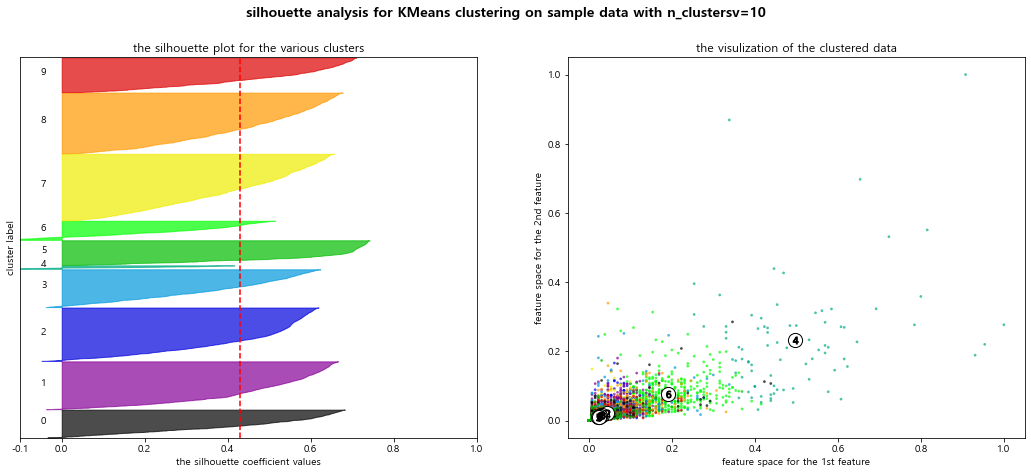

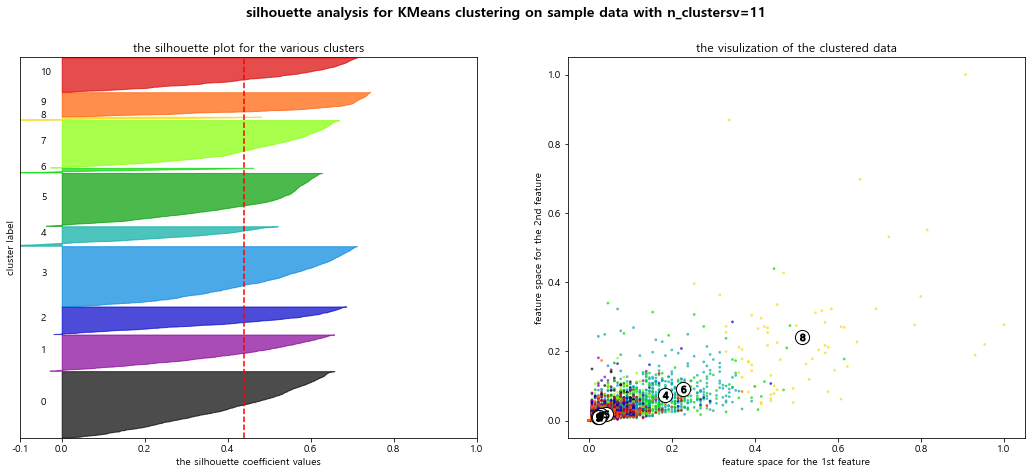

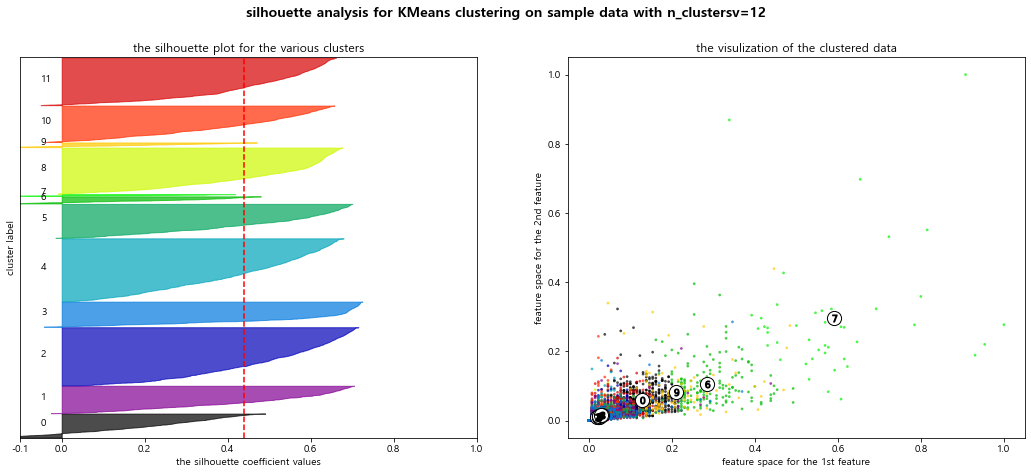

In [97]:
for n_clusters in range_n_clusters:
    # create a subplot with 1 row and 2 columns
    fig, (ax1, ax2)=plt.subplots(1,2)
    fig.set_size_inches(18,7)
    
    ax1.set_xlim([-0.1,1]) # 실루엣 계수는 -1,1 사이에 값이지만 이 실습에선 -0.1,1까지만 본다
    ax1.set_ylim([0,len(clusterDF)+(n_clusters+1)*10])
    
    clusterer=KMeans(n_clusters=n_clusters,random_state=10) #kmeans
    cluster_labels=clusterer.fit_predict(clusterDF)
    
    silhouette_avg=silhouette_score(clusterDF,cluster_labels)
    print('for n_clusters=',n_clusters,
         'the average silhouette_score is:',silhouette_avg)
    
    sample_silhouette_values=silhouette_samples(clusterDF,cluster_labels)
    
    y_lower=10
    for i in range(n_clusters):
        # n_clusters=2,3,4,5,6
        # i 는 0-n_clusters 즉, 분류된 군집의 라벨
        ith_cluster_silhouette_values=\
            sample_silhouette_values[cluster_labels==i]
        
        ith_cluster_silhouette_values.sort()
        size_cluster_i=ith_cluster_silhouette_values.shape[0]
        y_upper=y_lower+size_cluster_i
        
        color=cm.nipy_spectral(float(i)/n_clusters)
        ax1.fill_betweenx(np.arange(y_lower,y_upper),0,ith_cluster_silhouette_values,facecolor=color,edgecolor=color,alpha=0.7)
        ax1.text(-0.05,y_lower+0.5*size_cluster_i,str(i)) # 군집 번호를 가운데 표시
        y_lower=y_upper+10 # 다음 그림의 시작점 = 지금 그림의 끝점 + 10
        
    ax1.set_title('the silhouette plot for the various clusters')
    ax1.set_xlabel('the silhouette coefficient values')
    ax1.set_ylabel('cluster label')
    
    ax1.axvline(x=silhouette_avg,color='red',linestyle='--') # 모든 개별 데이터의 실루엣값 평균 보조선
    
    ax1.set_yticks([]) # y출 눈금 지우기
    ax1.set_xticks([-0.1,0,0.2,0.4,0.6,0.8,1])
    
    # 2번째 그래프 ax2
    colors=cm.nipy_spectral(cluster_labels.astype(float)/n_clusters)
    ax2.scatter(clusterDF[:,0],clusterDF[:,1],marker='.',s=30,lw=0,alpha=0.7,c=colors,edgecolor='k') #라벨에 따라 다른 색으로 산점도
    
    #군집의 중심에 원그림
    centers=clusterer.cluster_centers_
    ax2.scatter(centers[:,0],centers[:,1],marker='o',c='white',alpha=1,s=200,edgecolor='k')
    
    #군집의 중심에 군집번호 표시
    for i, c in enumerate(centers):
        ax2.scatter(c[0],c[1],marker='$%d$' % i, alpha=1,s=50,edgecolor='k')
        
    ax2.set_title('the visulization of the clustered data')
    ax2.set_xlabel('feature space for the 1st feature')
    ax2.set_ylabel('feature space for the 2nd feature')
    plt.suptitle(("silhouette analysis for KMeans clustering on sample data " "with n_clustersv=%d" % n_clusters),fontsize=14,fontweight='bold')
plt.show()

In [98]:
kmeans=KMeans(n_clusters=3, init='k-means++',max_iter=200,random_state=0)
cluster_labels=kmeans.fit_predict(DF[['frequency', 'monetary', 'recency']])
DF=pd.DataFrame(DF)
DF['label']=cluster_labels

In [99]:
DF.groupby(['label']).mean()

,frequency,monetary,recency
label,,,
0,3.408076,2.982376e+05,559.904915
1,52.985915,8.609113e+06,232.915493
2,18.048907,2.159541e+06,311.472425


**label=0**
R↑ F↓ M↓


**label=1**
R↓ F↑ M↑


**label=2**
R↓ F↓ M↓


In [100]:
DF['label'].value_counts()

0    7751
2     961
1      71
Name: label, dtype: int64

2) StandardScaler

for n_clusters= 2 the average silhouette_score is: 0.6290208645028398
for n_clusters= 3 the average silhouette_score is: 0.4684339276276415
for n_clusters= 4 the average silhouette_score is: 0.48619075039256204
for n_clusters= 5 the average silhouette_score is: 0.40443057566932017
for n_clusters= 6 the average silhouette_score is: 0.4201399270352579
for n_clusters= 7 the average silhouette_score is: 0.4216289326797126
for n_clusters= 8 the average silhouette_score is: 0.4241368812438126
for n_clusters= 9 the average silhouette_score is: 0.4189909555093846
for n_clusters= 10 the average silhouette_score is: 0.42201533645188033
for n_clusters= 11 the average silhouette_score is: 0.3893244025269238
for n_clusters= 12 the average silhouette_score is: 0.3915557778096961


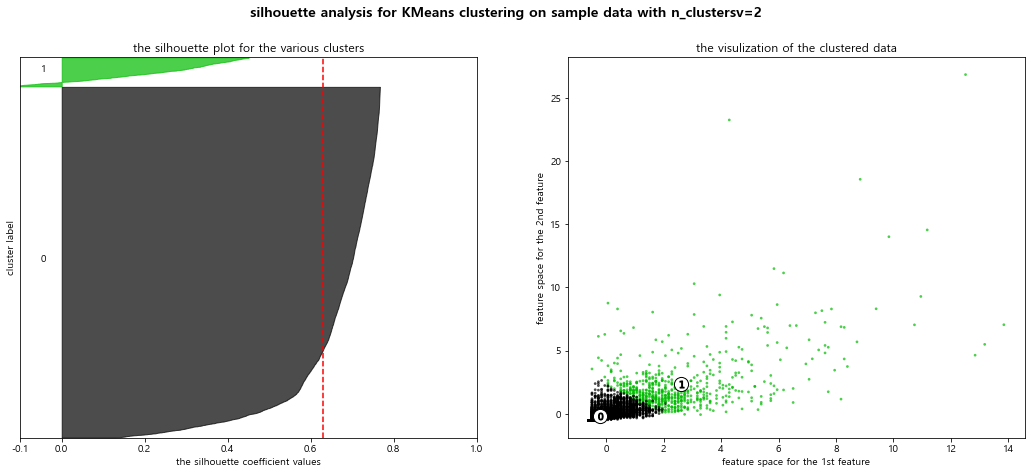

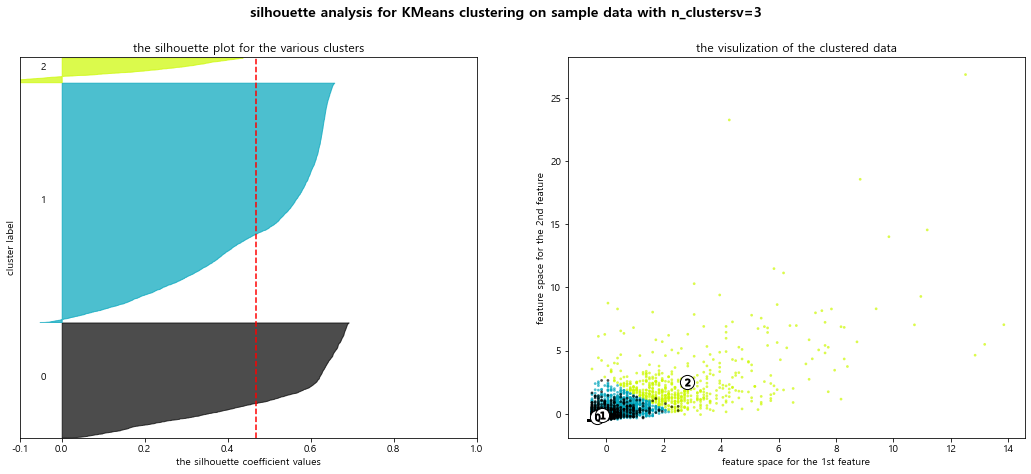

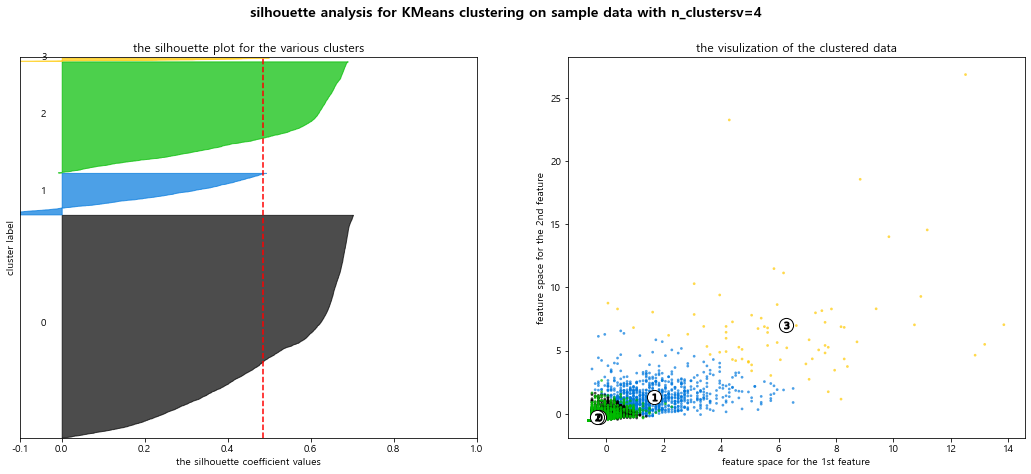

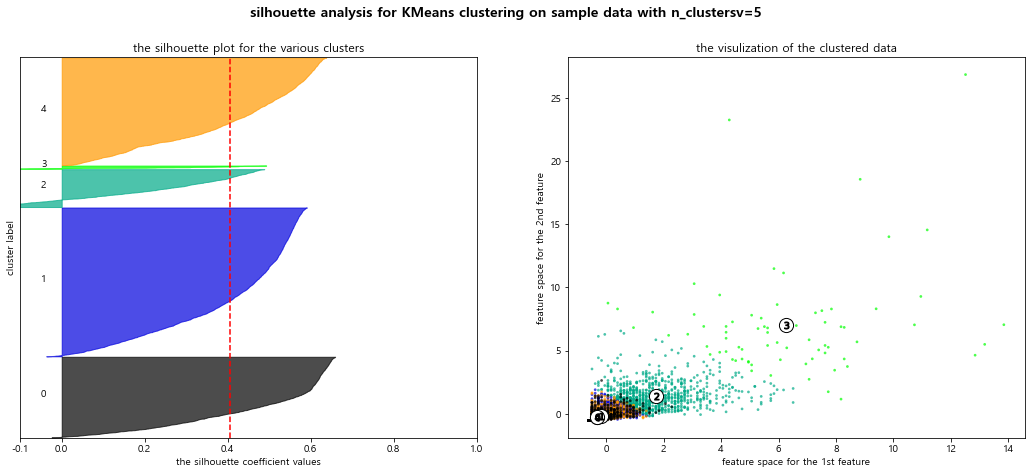

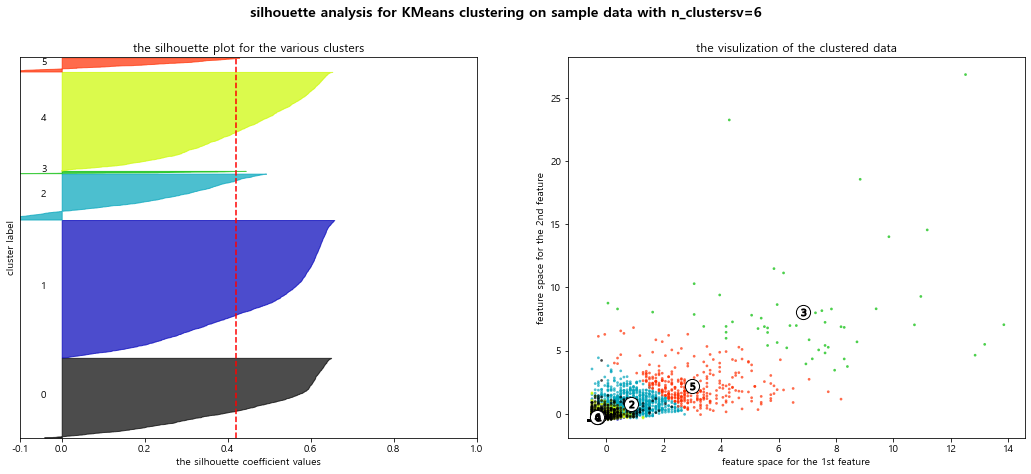

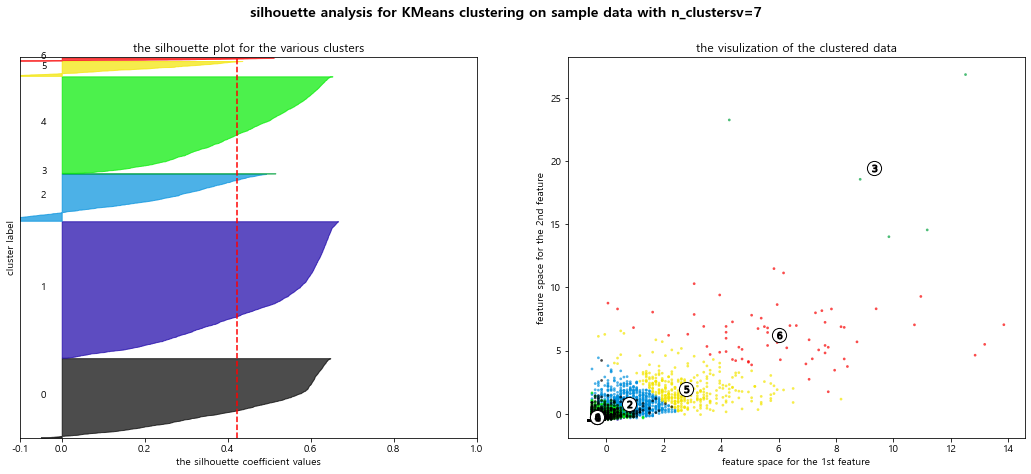

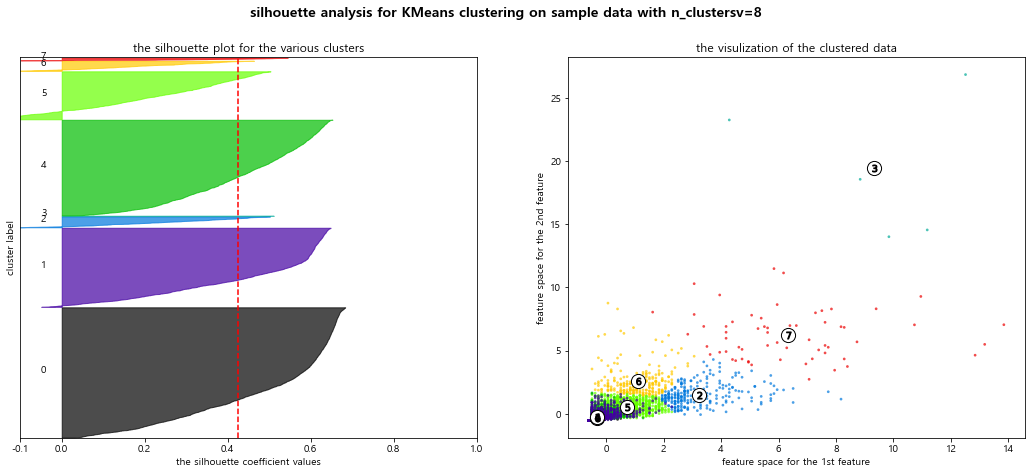

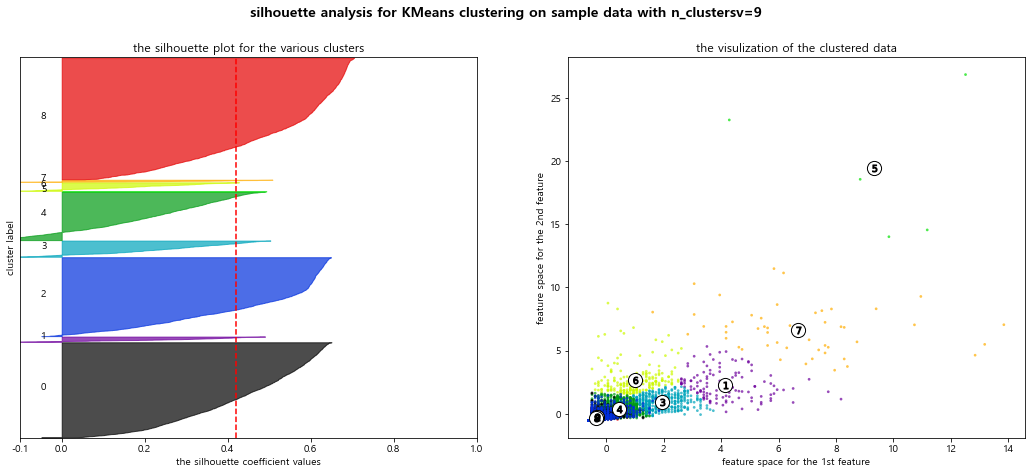

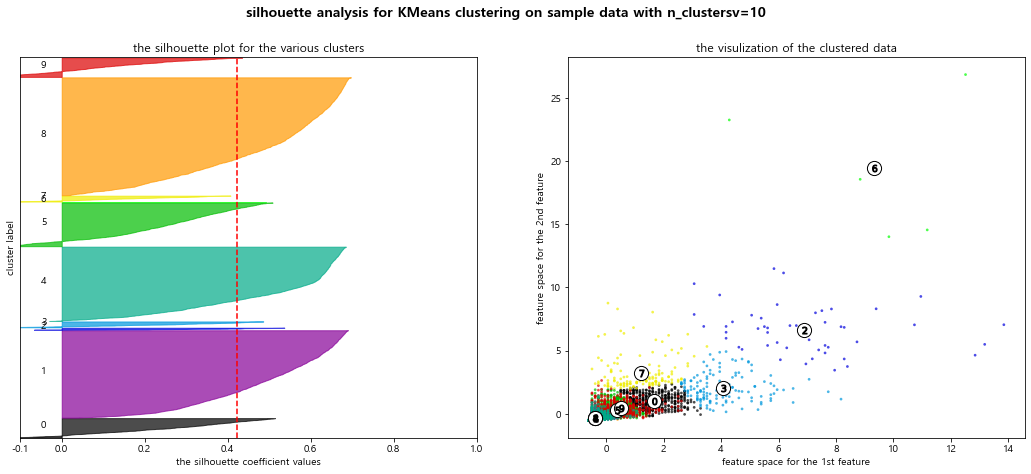

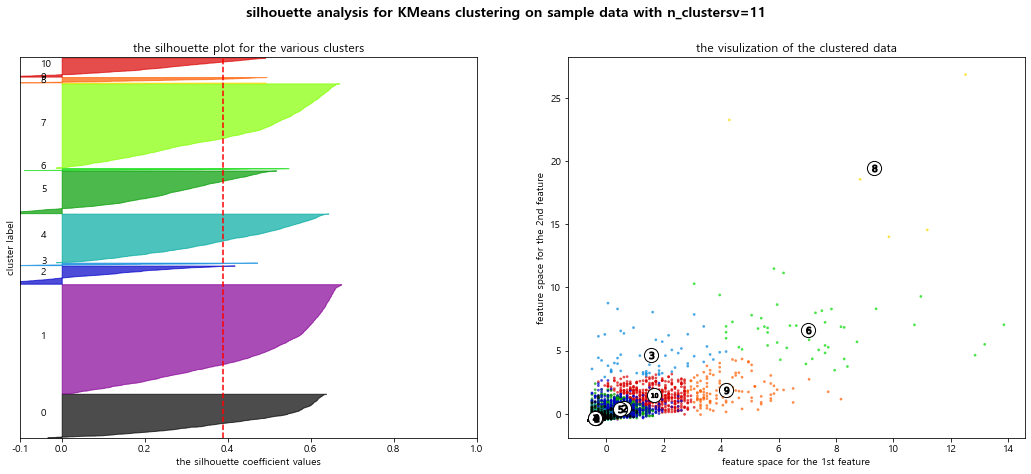

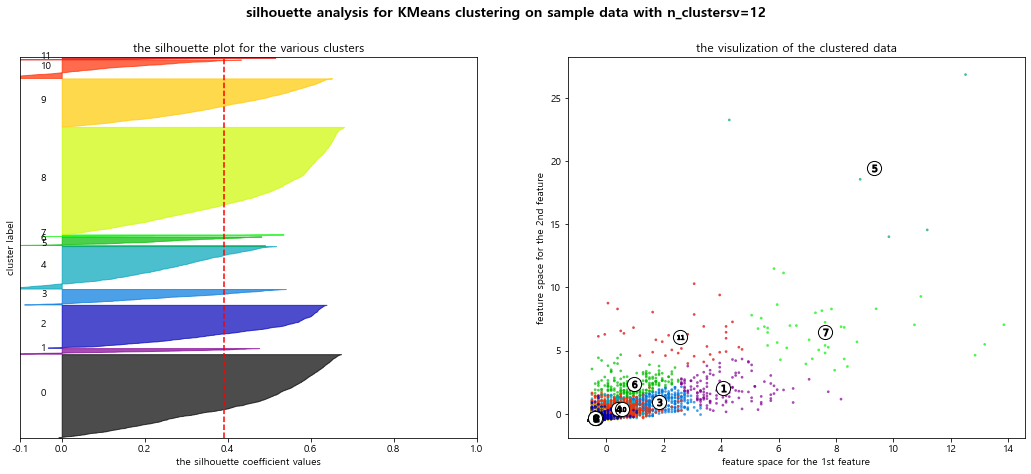

In [101]:
for n_clusters in range_n_clusters:
    # create a subplot with 1 row and 2 columns
    fig, (ax1, ax2)=plt.subplots(1,2)
    fig.set_size_inches(18,7)
    
    ax1.set_xlim([-0.1,1]) # 실루엣 계수는 -1,1 사이에 값이지만 이 실습에선 -0.1,1까지만 본다
    ax1.set_ylim([0,len(clusterDF2)+(n_clusters+1)*10])
    
    clusterer=KMeans(n_clusters=n_clusters,random_state=10) #kmeans
    cluster_labels=clusterer.fit_predict(clusterDF2)
    
    silhouette_avg=silhouette_score(clusterDF2,cluster_labels)
    print('for n_clusters=',n_clusters,
         'the average silhouette_score is:',silhouette_avg)
    
    sample_silhouette_values=silhouette_samples(clusterDF2,cluster_labels)
    
    y_lower=10
    for i in range(n_clusters):
        # n_clusters=2,3,4,5,6
        # i 는 0-n_clusters 즉, 분류된 군집의 라벨
        ith_cluster_silhouette_values=\
            sample_silhouette_values[cluster_labels==i]
        
        ith_cluster_silhouette_values.sort()
        size_cluster_i=ith_cluster_silhouette_values.shape[0]
        y_upper=y_lower+size_cluster_i
        
        color=cm.nipy_spectral(float(i)/n_clusters)
        ax1.fill_betweenx(np.arange(y_lower,y_upper),0,ith_cluster_silhouette_values,facecolor=color,edgecolor=color,alpha=0.7)
        ax1.text(-0.05,y_lower+0.5*size_cluster_i,str(i)) # 군집 번호를 가운데 표시
        y_lower=y_upper+10 # 다음 그림의 시작점 = 지금 그림의 끝점 + 10
        
    ax1.set_title('the silhouette plot for the various clusters')
    ax1.set_xlabel('the silhouette coefficient values')
    ax1.set_ylabel('cluster label')
    
    ax1.axvline(x=silhouette_avg,color='red',linestyle='--') # 모든 개별 데이터의 실루엣값 평균 보조선
    
    ax1.set_yticks([]) # y출 눈금 지우기
    ax1.set_xticks([-0.1,0,0.2,0.4,0.6,0.8,1])
    
    # 2번째 그래프 ax2
    colors=cm.nipy_spectral(cluster_labels.astype(float)/n_clusters)
    ax2.scatter(clusterDF2[:,0],clusterDF2[:,1],marker='.',s=30,lw=0,alpha=0.7,c=colors,edgecolor='k') #라벨에 따라 다른 색으로 산점도
    
    #군집의 중심에 원그림
    centers=clusterer.cluster_centers_
    ax2.scatter(centers[:,0],centers[:,1],marker='o',c='white',alpha=1,s=200,edgecolor='k')
    
    #군집의 중심에 군집번호 표시
    for i, c in enumerate(centers):
        ax2.scatter(c[0],c[1],marker='$%d$' % i, alpha=1,s=50,edgecolor='k')
        
    ax2.set_title('the visulization of the clustered data')
    ax2.set_xlabel('feature space for the 1st feature')
    ax2.set_ylabel('feature space for the 2nd feature')
    plt.suptitle(("silhouette analysis for KMeans clustering on sample data " "with n_clustersv=%d" % n_clusters),fontsize=14,fontweight='bold')
plt.show()

In [102]:
kmeans=KMeans(n_clusters=4, init='k-means++',max_iter=200,random_state=0)
cluster_labels=kmeans.fit_predict(DF[['frequency', 'monetary', 'recency']])
DF['label(ss)']=cluster_labels

In [103]:
DF.groupby(['label(ss)']).mean()

,frequency,monetary,recency,label
label(ss),,,,
0,3.326815,2.889300e+05,561.577239,0.000000
1,46.526882,6.848348e+06,263.698925,1.290323
2,89.400000,2.145976e+07,300.000000,1.000000
3,16.991124,2.009496e+06,317.358974,1.842209


**label(ss)=0**
R↑ F↓ M↓


**label(ss)=1**
R↓ F↑ M↑


**label(ss)=2**
R↑ F↑ M↑


**label(ss)=3**
R↑ F↓ M↑

In [104]:
DF['label(ss)'].value_counts()

0    7671
3    1014
1      93
2       5
Name: label(ss), dtype: int64

3) RobustScaler

for n_clusters= 2 the average silhouette_score is: 0.7531101649747552
for n_clusters= 3 the average silhouette_score is: 0.6628973123299694
for n_clusters= 4 the average silhouette_score is: 0.53020889952775
for n_clusters= 5 the average silhouette_score is: 0.5177927580478398
for n_clusters= 6 the average silhouette_score is: 0.38085500812517825
for n_clusters= 7 the average silhouette_score is: 0.3926008455597306
for n_clusters= 8 the average silhouette_score is: 0.39409943154942895
for n_clusters= 9 the average silhouette_score is: 0.4000890221897816
for n_clusters= 10 the average silhouette_score is: 0.4027225910221557
for n_clusters= 11 the average silhouette_score is: 0.39746111085075525
for n_clusters= 12 the average silhouette_score is: 0.39763977037815756


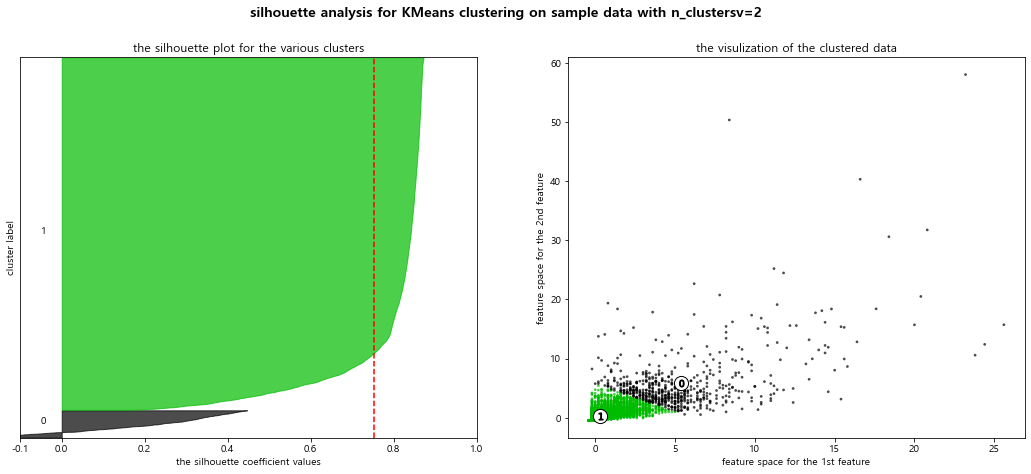

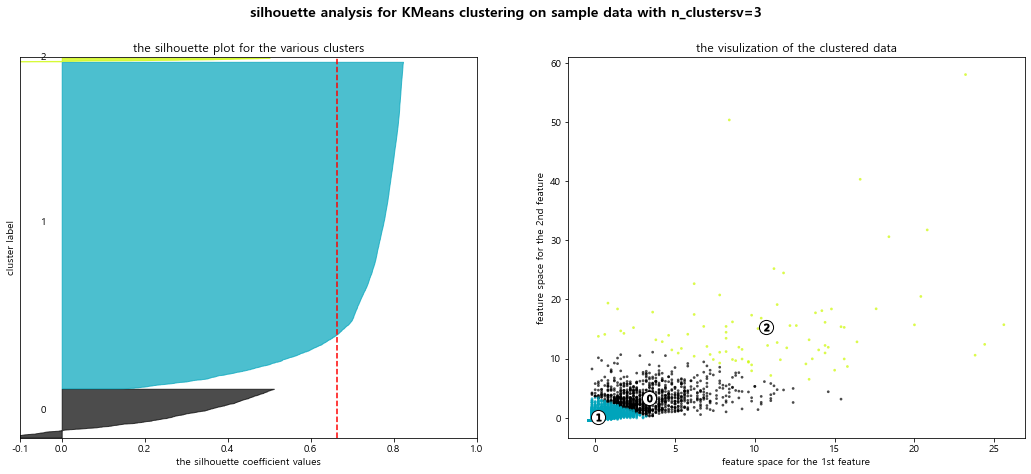

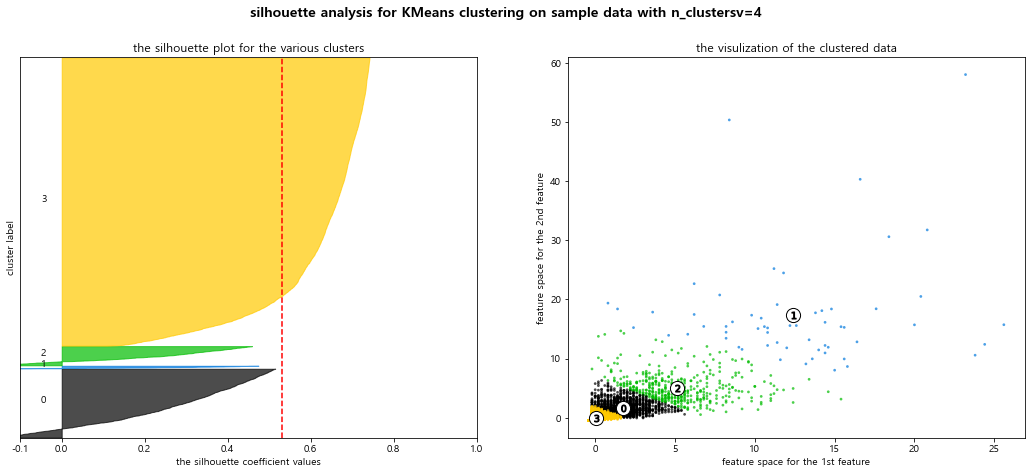

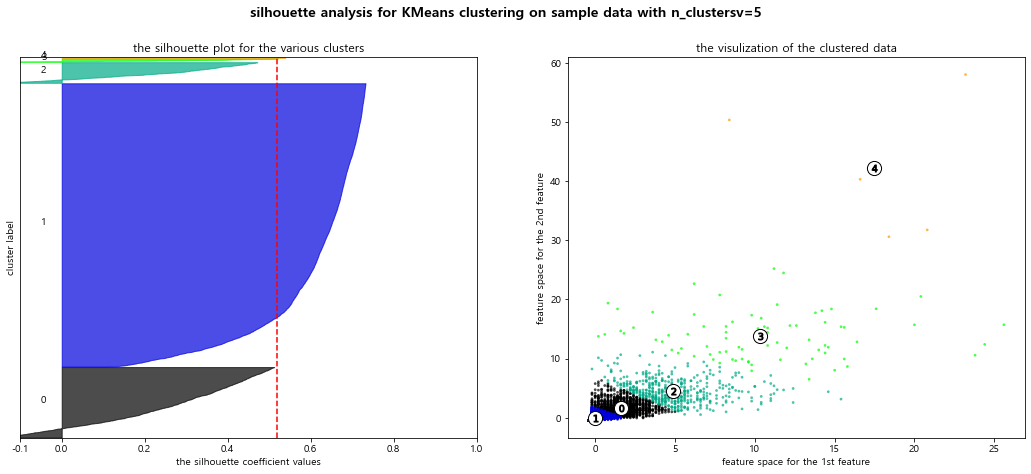

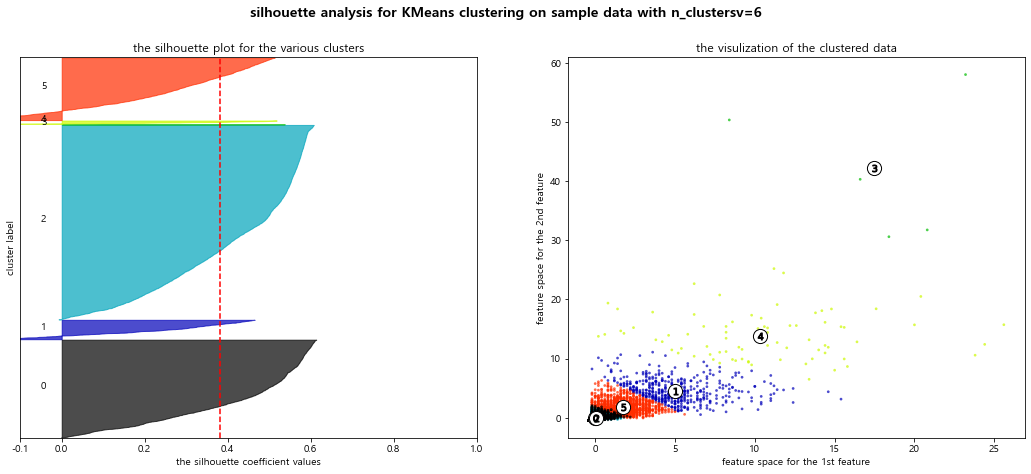

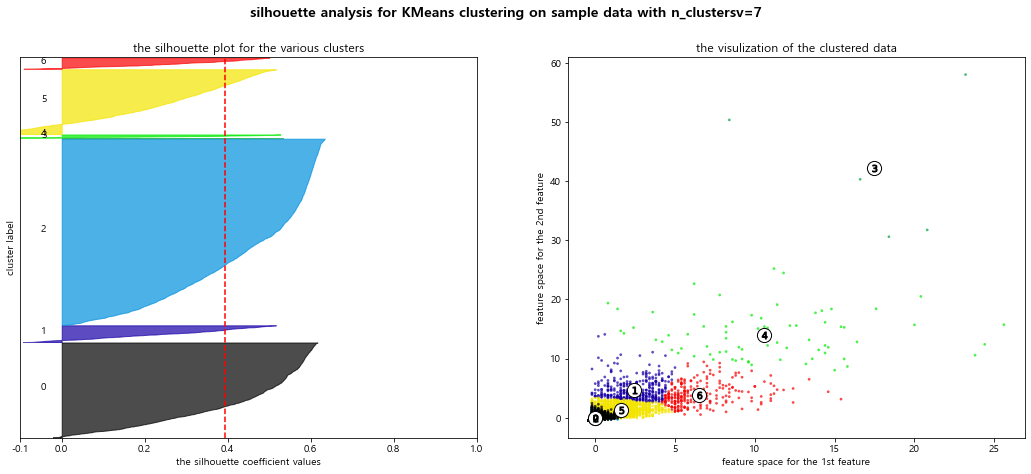

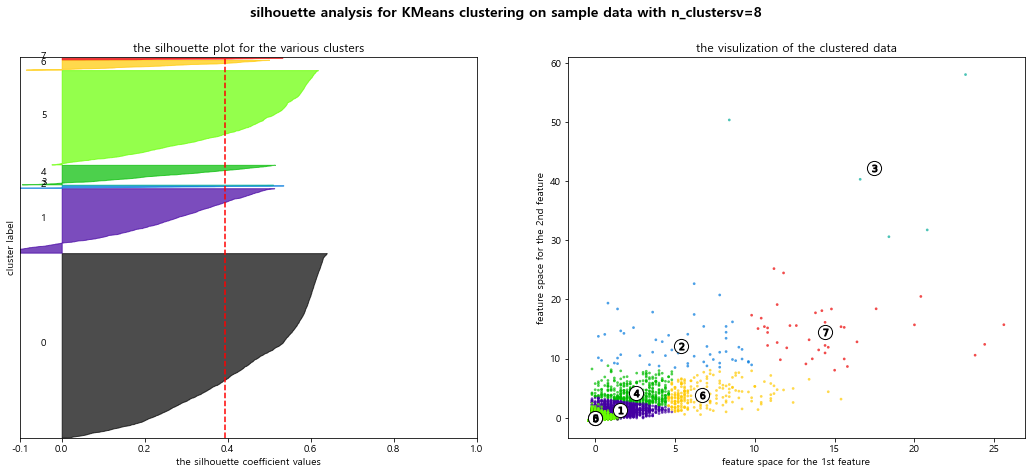

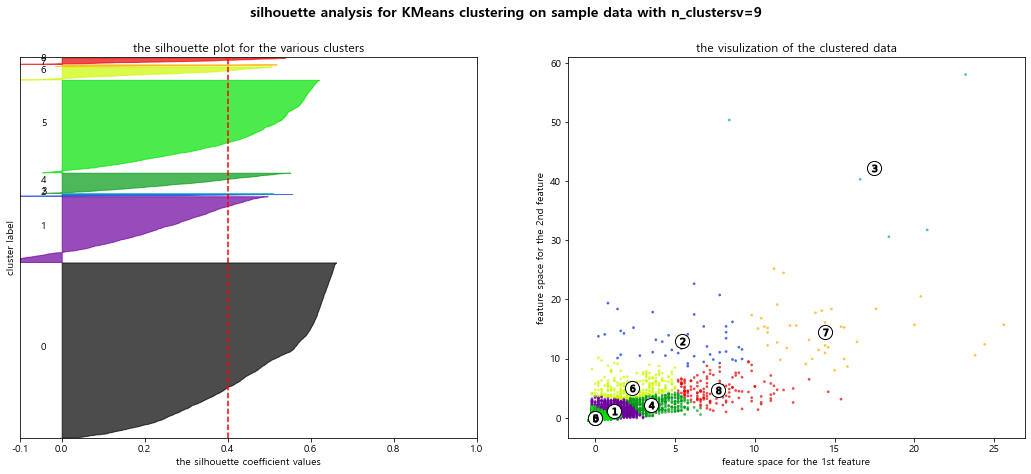

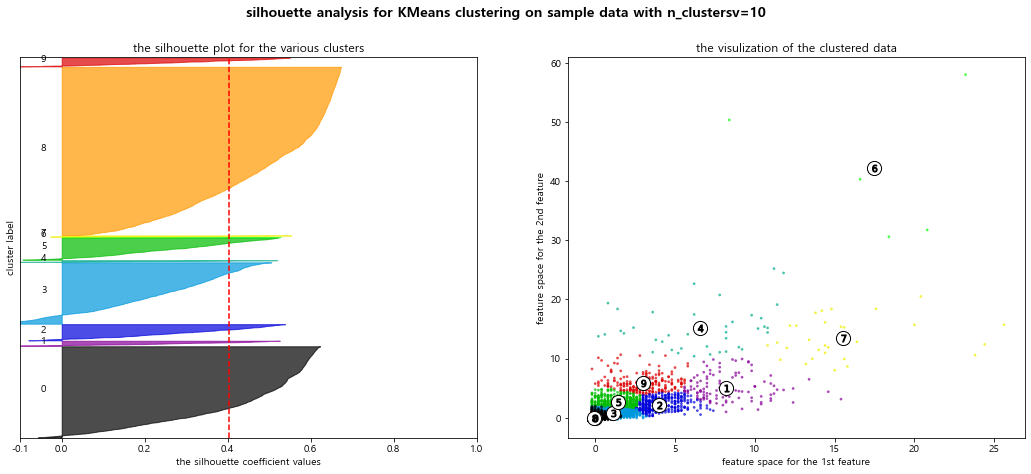

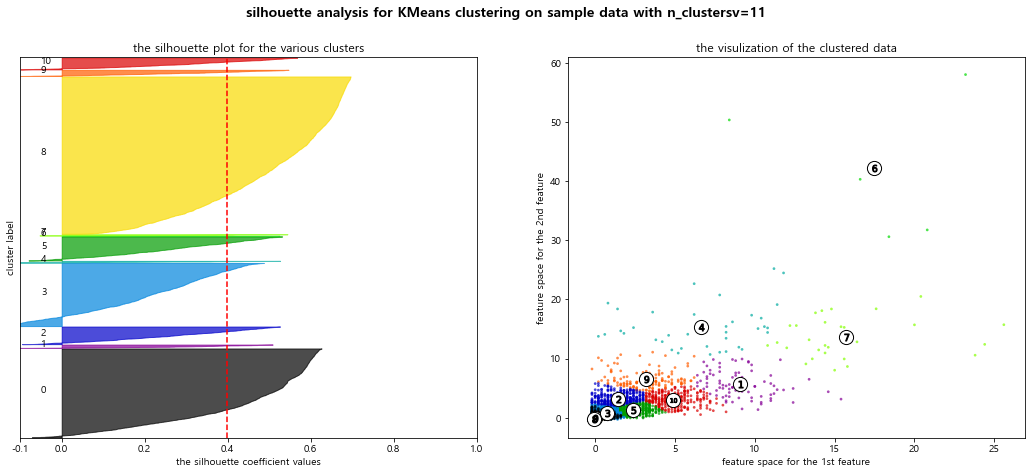

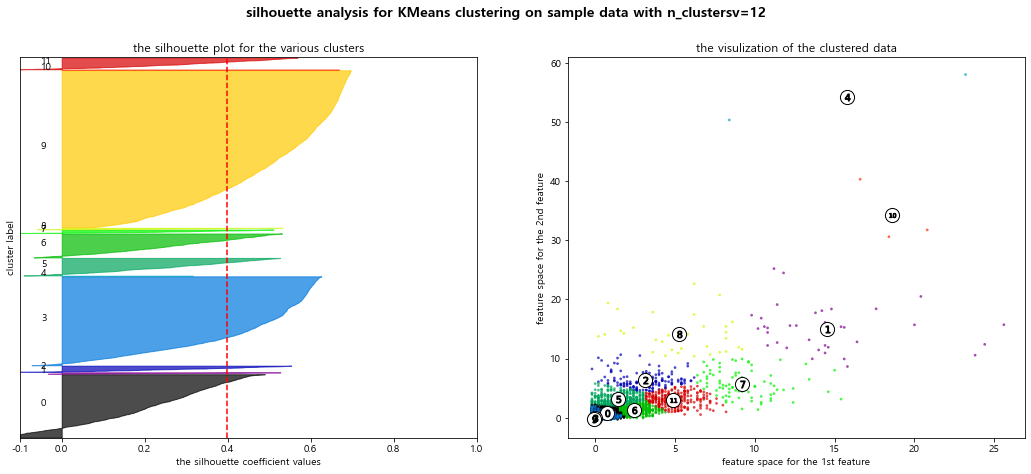

In [105]:
for n_clusters in range_n_clusters:
    # create a subplot with 1 row and 2 columns
    fig, (ax1, ax2)=plt.subplots(1,2)
    fig.set_size_inches(18,7)
    
    ax1.set_xlim([-0.1,1]) # 실루엣 계수는 -1,1 사이에 값이지만 이 실습에선 -0.1,1까지만 본다
    ax1.set_ylim([0,len(clusterDF3)+(n_clusters+1)*10])
    
    clusterer=KMeans(n_clusters=n_clusters,random_state=10) #kmeans
    cluster_labels=clusterer.fit_predict(clusterDF3)
    
    silhouette_avg=silhouette_score(clusterDF3,cluster_labels)
    print('for n_clusters=',n_clusters,
         'the average silhouette_score is:',silhouette_avg)
    
    sample_silhouette_values=silhouette_samples(clusterDF3,cluster_labels)
    
    y_lower=10
    for i in range(n_clusters):
        # n_clusters=2,3,4,5,6
        # i 는 0-n_clusters 즉, 분류된 군집의 라벨
        ith_cluster_silhouette_values=\
            sample_silhouette_values[cluster_labels==i]
        
        ith_cluster_silhouette_values.sort()
        size_cluster_i=ith_cluster_silhouette_values.shape[0]
        y_upper=y_lower+size_cluster_i
        
        color=cm.nipy_spectral(float(i)/n_clusters)
        ax1.fill_betweenx(np.arange(y_lower,y_upper),0,ith_cluster_silhouette_values,facecolor=color,edgecolor=color,alpha=0.7)
        ax1.text(-0.05,y_lower+0.5*size_cluster_i,str(i)) # 군집 번호를 가운데 표시
        y_lower=y_upper+10 # 다음 그림의 시작점 = 지금 그림의 끝점 + 10
        
    ax1.set_title('the silhouette plot for the various clusters')
    ax1.set_xlabel('the silhouette coefficient values')
    ax1.set_ylabel('cluster label')
    
    ax1.axvline(x=silhouette_avg,color='red',linestyle='--') # 모든 개별 데이터의 실루엣값 평균 보조선
    
    ax1.set_yticks([]) # y출 눈금 지우기
    ax1.set_xticks([-0.1,0,0.2,0.4,0.6,0.8,1])
    
    # 2번째 그래프 ax2
    colors=cm.nipy_spectral(cluster_labels.astype(float)/n_clusters)
    ax2.scatter(clusterDF3[:,0],clusterDF3[:,1],marker='.',s=30,lw=0,alpha=0.7,c=colors,edgecolor='k') #라벨에 따라 다른 색으로 산점도
    
    #군집의 중심에 원그림
    centers=clusterer.cluster_centers_
    ax2.scatter(centers[:,0],centers[:,1],marker='o',c='white',alpha=1,s=200,edgecolor='k')
    
    #군집의 중심에 군집번호 표시
    for i, c in enumerate(centers):
        ax2.scatter(c[0],c[1],marker='$%d$' % i, alpha=1,s=50,edgecolor='k')
        
    ax2.set_title('the visulization of the clustered data')
    ax2.set_xlabel('feature space for the 1st feature')
    ax2.set_ylabel('feature space for the 2nd feature')
    plt.suptitle(("silhouette analysis for KMeans clustering on sample data " "with n_clustersv=%d" % n_clusters),fontsize=14,fontweight='bold')
plt.show()

In [106]:
kmeans=KMeans(n_clusters=3, init='k-means++',max_iter=200,random_state=0)
cluster_labels=kmeans.fit_predict(DF[['frequency', 'monetary', 'recency']])
DF['label(rs)']=cluster_labels

In [107]:
DF.groupby(['label(rs)']).mean()

,frequency,monetary,recency,label,label(ss)
label(rs),,,,,
0,3.408076,2.982376e+05,559.904915,0.0,0.030964
1,52.985915,8.609113e+06,232.915493,1.0,1.070423
2,18.048907,2.159541e+06,311.472425,2.0,2.943809


In [108]:
DF['label(rs)'].value_counts()

0    7751
2     961
1      71
Name: label(rs), dtype: int64

**label(rs)=0**
R↑ F↓ M↓


**label(rs)=1**
R↓ F↑ M↑


**label(rs)=2**
R↓ F↓ M↓


In [109]:
pos.set_index('고객번호',inplace=True)

In [110]:
customer=pd.concat([pos,DF],axis=1)
customer.drop(['frequency','monetary','recency'],axis=1,inplace=True)
customer.reset_index(inplace=True)

In [111]:
customer

,고객번호,고객명,매장명,등급,성별,구매금액,구매횟수,포인트,가입일,최종방문일,문자수신여부,연락처,label,label(ss),label(rs)
0,00042050,이연수,갈비명가이상 답십리점,일반,여자,1431000,24,14420,2015-02-27,2017-01-25 00:00:00,N,01074458308,2,3,2
1,00042051,김국동,갈비명가이상 답십리점,일반,남자,6176900,62,10209,2015-02-27,2018-11-03 00:00:00,N,01037358580,1,1,1
2,00042052,장종철,갈비명가이상 답십리점,일반,남자,1615300,15,6153,2015-02-27,2020-08-02 00:00:00,N,01067228446,2,3,2
3,00042062,이지영,갈비명가이상 답십리점,일반,여자,834000,22,5290,2015-02-27,2017-03-06 00:00:00,N,01091837812,0,0,0
4,00042078,이주한,갈비명가이상 답십리점,일반,남자,1653400,28,8094,2015-02-28,2017-12-28 00:00:00,N,01033939229,2,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8778,00106402,유혁림,갈비명가이상 답십리점,일반,남자,140000,1,1400,2020-12-30,2020-12-30 00:00:00,Y,01062107182,0,0,0
8779,00106404,김대진,갈비명가이상 답십리점,일반,남자,52000,1,520,2020-12-30,2020-12-30 00:00:00,Y,01074718233,0,0,0
8780,00106408,박선미,갈비명가이상 답십리점,일반,여자,126000,1,1260,2020-12-30,2020-12-30 00:00:00,Y,01028640977,0,0,0
8781,00106421,송미령,갈비명가이상 답십리점,일반,여자,28000,1,280,2020-12-31,2020-12-31 00:00:00,Y,01031676524,0,0,0


In [112]:
customer.to_excel('./답십리고객분류.xlsx', index=False, encoding='cp949')